## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import interpolation
import math
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Load Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

## utility function

### graph

In [3]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

### alphabet image

In [4]:
def digit_image(x):
    return np.where(x>=150, x, 0)

### alphabet one-hot encoding

In [5]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

### Deskew

In [6]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [7]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [8]:
def deskew_all(image_data):
    deskewed = []
    
    for i in range(len(image_data)):
        deskewed.append(deskew(image_data[i].reshape(28,28)))
    
    return np.array(deskewed)[:,:,:,np.newaxis]

## EDA

In [9]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [10]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [11]:
pd.value_counts(train['letter'])

Z    91
K    90
O    90
L    89
H    89
G    87
Y    86
M    86
U    85
T    82
Q    82
R    81
F    80
X    79
N    77
S    76
D    76
C    74
V    73
A    72
B    71
W    69
J    67
P    66
E    66
I    64
Name: letter, dtype: int64

In [12]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [13]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

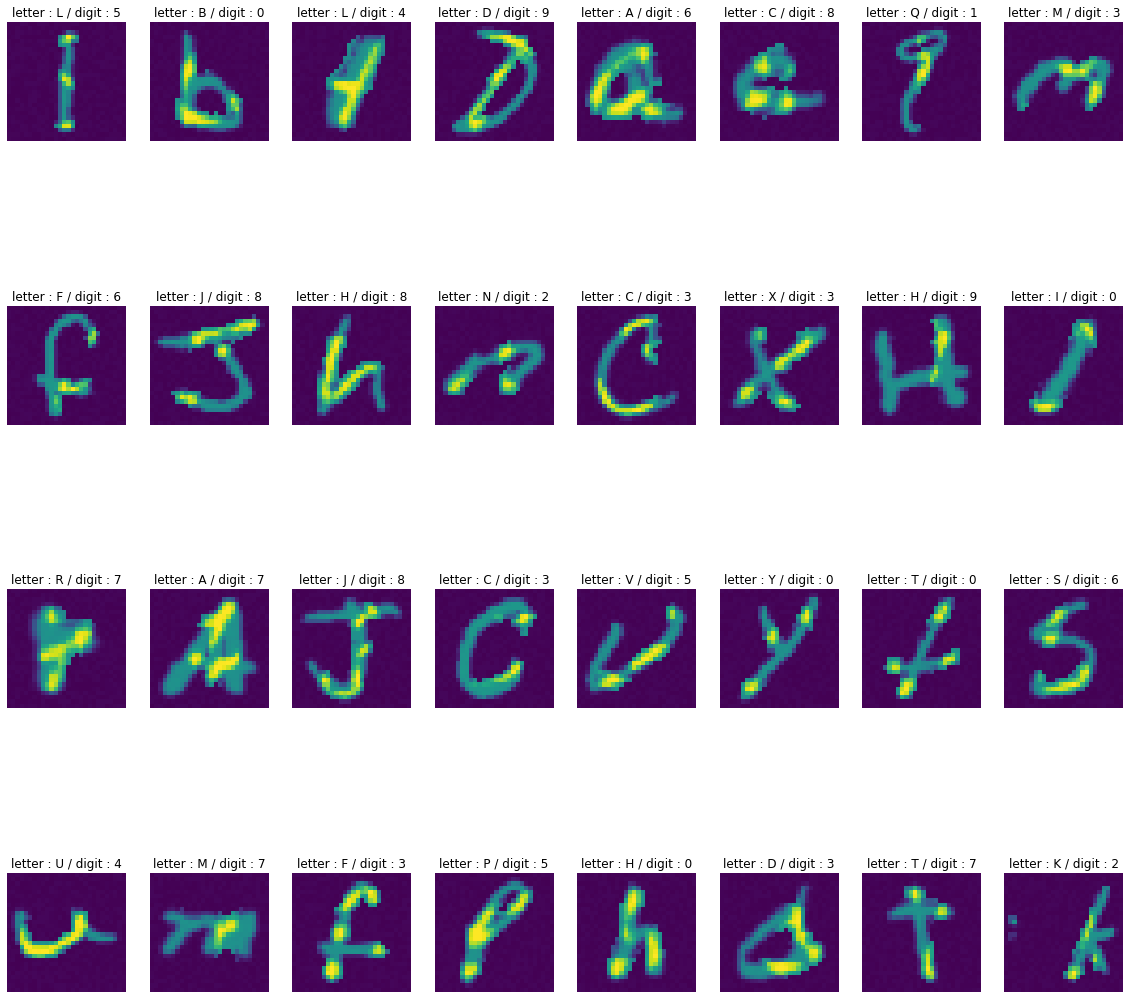

In [14]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

## Dataset 

In [15]:
X_train = train.drop(['letter','id','digit'],axis=1)
X_test = test.drop(['letter','id'],axis=1)

In [16]:
X_trains = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [17]:
X_trains.shape

(2048, 28, 28, 1)

In [18]:
X_test.shape

(20480, 28, 28, 1)

In [19]:
X_trains = deskew_all(X_trains)
X_test = deskew_all(X_test)

In [20]:
y_trains = train['digit']

In [21]:
y_trains = utils.to_categorical(y_trains, 10)

In [22]:
y_trains.shape

(2048, 10)

In [23]:
X_train_digit = digit_image(X_trains)
X_test_digit = digit_image(X_test)

In [24]:
X_train_alpha = X_trains - X_train_digit/2
X_test_alpha = X_test - X_test_digit/2

In [25]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
X_test = np.concatenate((X_test, X_test_digit, X_test_alpha),axis=-1)

In [26]:
X_trains.shape

(2048, 28, 28, 3)

In [27]:
X_test.shape

(20480, 28, 28, 3)

## Train

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [29]:
reduction_ratio=16

In [30]:
input_ = tf.keras.layers.Input(shape=(28,28,3))

conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(input_) #28x28x128


## Residual Unit1
batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
elu1_1 = tf.keras.layers.ELU()(batch1_1)
res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
elu1_2 = tf.keras.layers.ELU()(batch1_2)
res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
elu1_3 = tf.keras.layers.ELU()(batch1_3)
res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

# SEBlock1
ch_input1 = 128
ch_reduced1 = ch_input1//reduction_ratio
avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
#

skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
##

## Residual Unit2
batch2_1 = tf.keras.layers.BatchNormalization()(res1)
elu2_1 = tf.keras.layers.ELU()(batch2_1)
res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
elu2_2 = tf.keras.layers.ELU()(batch2_2)
res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
elu2_3 = tf.keras.layers.ELU()(batch2_3)
res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


# SEBlock2
ch_input2 = 128
ch_reduced2 = ch_input2//reduction_ratio
avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
#
skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
res2 = tf.keras.layers.Add()([mul2, skip2])
drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
##


## Residual Unit3
batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
elu3_1 = tf.keras.layers.ELU()(batch3_1)
res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
elu3_2 = tf.keras.layers.ELU()(batch3_2)
res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
elu3_3 = tf.keras.layers.ELU()(batch3_3)
res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


# SEBlock3
ch_input3 = 128
ch_reduced3 = ch_input3//reduction_ratio
avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
#
skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
##


## Residual Unit4
batch4_1 = tf.keras.layers.BatchNormalization()(res3)
elu4_1 = tf.keras.layers.ELU()(batch4_1)
res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
elu4_2 = tf.keras.layers.ELU()(batch4_2)
res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
elu4_3 = tf.keras.layers.ELU()(batch4_3)
res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


# SEBlock4
ch_input4 = 256
ch_reduced4 = ch_input4//reduction_ratio
avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
#
skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
res4 = tf.keras.layers.Add()([mul4, skip4])
pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
##


## Residual Unit5
batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
elu5_1 = tf.keras.layers.ELU()(batch5_1)
res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
elu5_2 = tf.keras.layers.ELU()(batch5_2)
res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
elu5_3 = tf.keras.layers.ELU()(batch5_3)
res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


# SEBlock5
ch_input5 = 256
ch_reduced5 = ch_input5//reduction_ratio
avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
#
skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
res5 = tf.keras.layers.Add()([mul5, skip5])
pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
##


## Residual Unit6
batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
elu6_1 = tf.keras.layers.ELU()(batch6_1)
res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
elu6_2 = tf.keras.layers.ELU()(batch6_2)
res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
elu6_3 = tf.keras.layers.ELU()(batch6_3)
res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
# SEBlock6
ch_input6 = 256
ch_reduced6 = ch_input6//reduction_ratio
avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
#
skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
res6 = tf.keras.layers.Add()([mul6, skip6])
drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
##

## Residual Unit7
batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
elu7_1 = tf.keras.layers.ELU()(batch7_1)
res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
elu7_2 = tf.keras.layers.ELU()(batch7_2)
res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
elu7_3 = tf.keras.layers.ELU()(batch7_3)
res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
res7 = tf.keras.layers.Add()([res7_3, skip7])
pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) # 2x2x512


# flatten1 = tf.keras.layers.Flatten()(pool7)
# dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
gap = tf.keras.layers.GlobalAveragePooling2D()(pool7)
dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(gap)

drop10 = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(10 ,activation='softmax')(drop10)


In [31]:
datagen = ImageDataGenerator(
#     rotation_range=30,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
#     zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [32]:
epochs=500
batch_size = 32
num_model = 10

model_1
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 27s 535ms/step - loss: 3.6854 - accuracy: 0.1164 - val_loss: 2.4510 - val_accuracy: 0.1195 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 47ms/step - loss: 2.6414 - accuracy: 0.1370 - val_loss: 2.3089 - val_accuracy: 0.1756 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 42ms/step - loss: 2.5253 - accuracy: 0.1258 - val_loss: 2.2811 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 46ms/step - loss: 2.4705 - accuracy: 0.1376 - val_loss: 2.2672 - val_accuracy: 0.1805 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 2.4167 - accuracy: 0.1482 - val_loss: 2.5074 - val_accuracy: 0.1805 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 46ms/step - loss: 2.3054 - accuracy: 

Epoch 53/500
51/51 [==============================] - 2s 42ms/step - loss: 1.1864 - accuracy: 0.5797 - val_loss: 1.1671 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 54/500
51/51 [==============================] - 2s 42ms/step - loss: 1.1502 - accuracy: 0.5872 - val_loss: 1.3454 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 55/500
51/51 [==============================] - 2s 42ms/step - loss: 1.1476 - accuracy: 0.6015 - val_loss: 1.3185 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 56/500
51/51 [==============================] - 2s 42ms/step - loss: 1.1858 - accuracy: 0.5859 - val_loss: 0.9063 - val_accuracy: 0.7122 - lr: 0.0010
Epoch 57/500
51/51 [==============================] - 2s 42ms/step - loss: 1.1516 - accuracy: 0.5903 - val_loss: 0.9714 - val_accuracy: 0.7122 - lr: 0.0010
Epoch 58/500
51/51 [==============================] - 2s 45ms/step - loss: 1.1685 - accuracy: 0.6009 - val_loss: 0.8737 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 59/500
51/51 [==============================] - 2s 42ms/st

51/51 [==============================] - 2s 42ms/step - loss: 0.8274 - accuracy: 0.7077 - val_loss: 0.8181 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 106/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8661 - accuracy: 0.7061 - val_loss: 0.7939 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 107/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8969 - accuracy: 0.6905 - val_loss: 0.6455 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 108/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8757 - accuracy: 0.7005 - val_loss: 0.9980 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 109/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8572 - accuracy: 0.7123 - val_loss: 0.7900 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 110/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8226 - accuracy: 0.7161 - val_loss: 0.8413 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 111/500
51/51 [==============================] - 2s 42ms/step - lo

51/51 [==============================] - 2s 42ms/step - loss: 0.5579 - accuracy: 0.8014 - val_loss: 0.6620 - val_accuracy: 0.8244 - lr: 4.9000e-04
Epoch 157/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5271 - accuracy: 0.8229 - val_loss: 0.6823 - val_accuracy: 0.8220 - lr: 4.9000e-04
Epoch 158/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5131 - accuracy: 0.8194 - val_loss: 0.6736 - val_accuracy: 0.8220 - lr: 4.9000e-04
Epoch 159/500
51/51 [==============================] - 2s 46ms/step - loss: 0.5112 - accuracy: 0.8225 - val_loss: 0.6027 - val_accuracy: 0.8439 - lr: 4.9000e-04
Epoch 160/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5114 - accuracy: 0.8182 - val_loss: 0.7258 - val_accuracy: 0.8220 - lr: 4.9000e-04
Epoch 161/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5195 - accuracy: 0.8057 - val_loss: 0.7695 - val_accuracy: 0.8220 - lr: 4.9000e-04
Epoch 162/500
51/51 [===========================

Epoch 207/500
51/51 [==============================] - 2s 46ms/step - loss: 0.3539 - accuracy: 0.8680 - val_loss: 0.5783 - val_accuracy: 0.8585 - lr: 2.4010e-04
Epoch 208/500
51/51 [==============================] - 2s 46ms/step - loss: 0.3491 - accuracy: 0.8780 - val_loss: 0.5663 - val_accuracy: 0.8610 - lr: 2.4010e-04
Epoch 209/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3523 - accuracy: 0.8707 - val_loss: 0.6118 - val_accuracy: 0.8415 - lr: 2.4010e-04
Epoch 210/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3514 - accuracy: 0.8761 - val_loss: 0.6438 - val_accuracy: 0.8317 - lr: 2.4010e-04
Epoch 211/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3852 - accuracy: 0.8655 - val_loss: 0.7008 - val_accuracy: 0.8317 - lr: 2.4010e-04
Epoch 212/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3471 - accuracy: 0.8780 - val_loss: 0.6400 - val_accuracy: 0.8244 - lr: 2.4010e-04
Epoch 213/500
51/51 [=============

Epoch 258/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2881 - accuracy: 0.9004 - val_loss: 0.8304 - val_accuracy: 0.8341 - lr: 1.6807e-04
Epoch 259/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2874 - accuracy: 0.9010 - val_loss: 0.6637 - val_accuracy: 0.8488 - lr: 1.1765e-04
Epoch 260/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2738 - accuracy: 0.9072 - val_loss: 0.5763 - val_accuracy: 0.8659 - lr: 1.1765e-04
Epoch 261/500
51/51 [==============================] - 2s 43ms/step - loss: 0.2902 - accuracy: 0.9013 - val_loss: 0.5939 - val_accuracy: 0.8659 - lr: 1.1765e-04
Epoch 262/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3200 - accuracy: 0.8861 - val_loss: 0.7191 - val_accuracy: 0.8341 - lr: 1.1765e-04
Epoch 263/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2648 - accuracy: 0.9078 - val_loss: 0.6427 - val_accuracy: 0.8512 - lr: 1.1765e-04
Epoch 264/500
51/51 [=============

Epoch 309/500
51/51 [==============================] - 2s 41ms/step - loss: 0.2553 - accuracy: 0.9078 - val_loss: 0.7203 - val_accuracy: 0.8366 - lr: 8.2354e-05
Epoch 310/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2831 - accuracy: 0.8985 - val_loss: 0.6975 - val_accuracy: 0.8317 - lr: 8.2354e-05
Epoch 311/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2492 - accuracy: 0.9047 - val_loss: 0.6755 - val_accuracy: 0.8488 - lr: 8.2354e-05
Epoch 312/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2311 - accuracy: 0.9110 - val_loss: 0.6306 - val_accuracy: 0.8585 - lr: 8.2354e-05
Epoch 313/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2407 - accuracy: 0.9142 - val_loss: 0.6953 - val_accuracy: 0.8512 - lr: 8.2354e-05
Epoch 314/500
51/51 [==============================] - 2s 43ms/step - loss: 0.2256 - accuracy: 0.9234 - val_loss: 0.6715 - val_accuracy: 0.8585 - lr: 8.2354e-05
Epoch 315/500
51/51 [=============

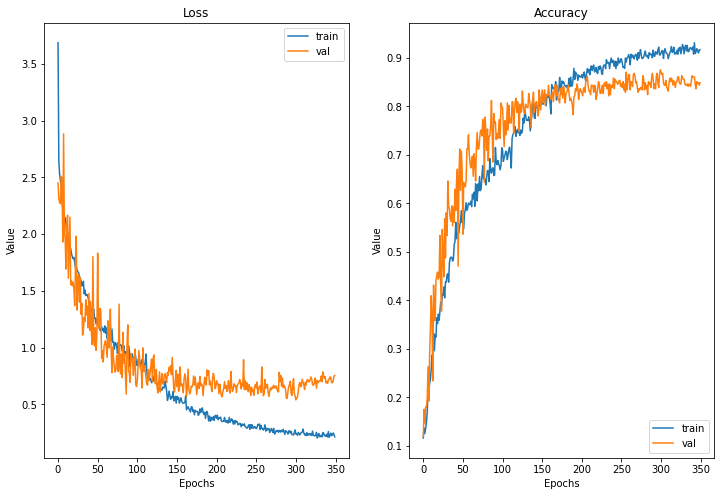

model_2
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 53ms/step - loss: 0.7497 - accuracy: 0.7653 - val_loss: 0.1982 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6885 - accuracy: 0.7771 - val_loss: 0.1908 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 41ms/step - loss: 0.7006 - accuracy: 0.7609 - val_loss: 0.4432 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 41ms/step - loss: 0.6618 - accuracy: 0.7702 - val_loss: 0.2333 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7174 - accuracy: 0.7603 - val_loss: 0.4012 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6640 - accuracy: 0.

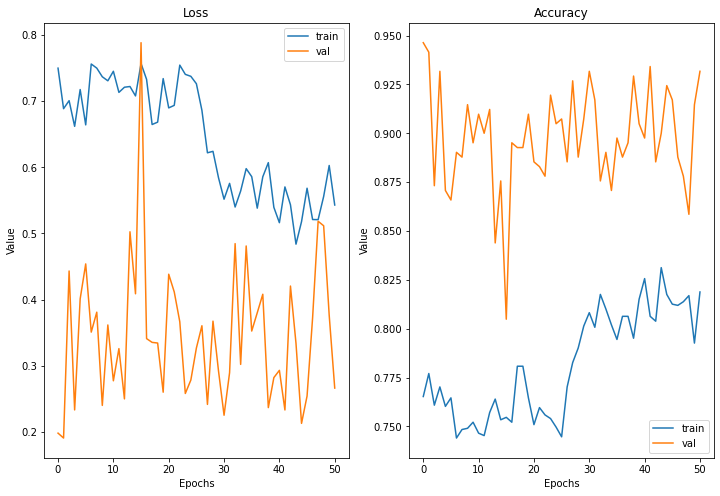

model_3
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 53ms/step - loss: 0.7489 - accuracy: 0.7482 - val_loss: 0.2493 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 47ms/step - loss: 0.7004 - accuracy: 0.7584 - val_loss: 0.2070 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6426 - accuracy: 0.7746 - val_loss: 0.3960 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6559 - accuracy: 0.7671 - val_loss: 0.3650 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7498 - accuracy: 0.7460 - val_loss: 0.2200 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6940 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.5712 - accuracy: 0.7958 - val_loss: 0.3540 - val_accuracy: 0.9000 - lr: 7.0000e-04


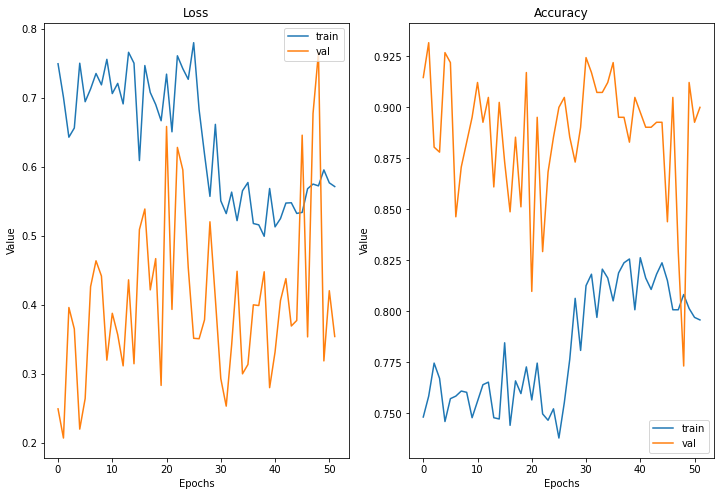

model_4
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 56ms/step - loss: 0.6970 - accuracy: 0.7647 - val_loss: 0.1867 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 42ms/step - loss: 0.8589 - accuracy: 0.7267 - val_loss: 0.3110 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7383 - accuracy: 0.7578 - val_loss: 0.2513 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6997 - accuracy: 0.7684 - val_loss: 0.2178 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7709 - accuracy: 0.7360 - val_loss: 0.4096 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 43ms/step - loss: 0.7725 - accuracy: 0.

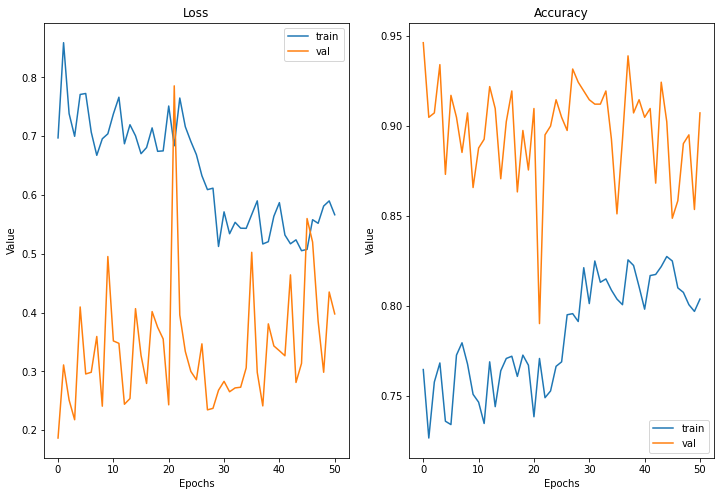

model_5
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 54ms/step - loss: 0.7856 - accuracy: 0.7463 - val_loss: 0.6404 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 47ms/step - loss: 0.7724 - accuracy: 0.7347 - val_loss: 0.3823 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 46ms/step - loss: 0.7280 - accuracy: 0.7366 - val_loss: 0.2271 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7235 - accuracy: 0.7572 - val_loss: 0.2986 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 45ms/step - loss: 0.7199 - accuracy: 0.7547 - val_loss: 0.2700 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7147 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.5238 - accuracy: 0.8088 - val_loss: 0.3548 - val_accuracy: 0.8902 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 43ms/step - loss: 0.5312 - accuracy: 0.8137 - val_loss: 0.5642 - val_accuracy: 0.8561 - lr: 7.0000e-04
Epoch 54/500
51/51 [==============================] - 2s 43ms/step - loss: 0.4810 - accuracy: 0.8356 - val_loss: 0.2470 - val_accuracy: 0.9293 - lr: 4.9000e-04
Epoch 55/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4136 - accuracy: 0.8524 - val_loss: 0.3155 - val_accuracy: 0.9195 - lr: 4.9000e-04


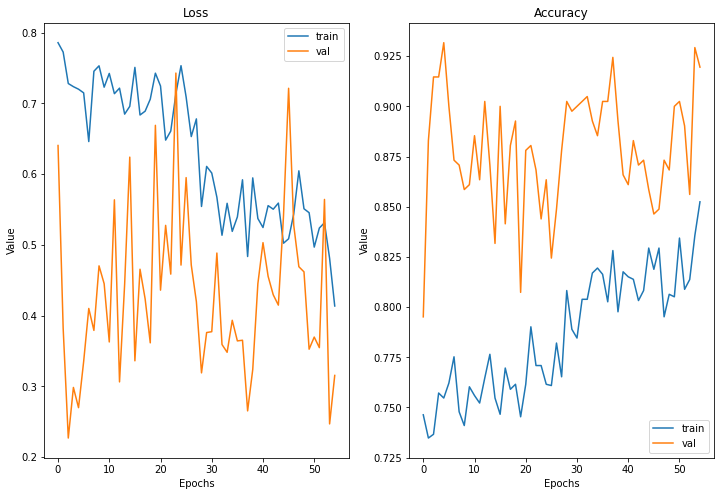

model_6
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 54ms/step - loss: 0.8185 - accuracy: 0.7243 - val_loss: 0.2231 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 43ms/step - loss: 0.7641 - accuracy: 0.7416 - val_loss: 0.2580 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7274 - accuracy: 0.7516 - val_loss: 0.3264 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7310 - accuracy: 0.7472 - val_loss: 0.4858 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 41ms/step - loss: 0.7927 - accuracy: 0.7354 - val_loss: 0.4045 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7979 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.4666 - accuracy: 0.8418 - val_loss: 0.4752 - val_accuracy: 0.8780 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 45ms/step - loss: 0.5347 - accuracy: 0.8137 - val_loss: 0.2798 - val_accuracy: 0.9146 - lr: 7.0000e-04
Epoch 54/500
51/51 [==============================] - 2s 44ms/step - loss: 0.5174 - accuracy: 0.8101 - val_loss: 0.4213 - val_accuracy: 0.8683 - lr: 7.0000e-04
Epoch 55/500
51/51 [==============================] - 2s 45ms/step - loss: 0.5450 - accuracy: 0.8176 - val_loss: 0.3542 - val_accuracy: 0.8902 - lr: 7.0000e-04
Epoch 56/500
51/51 [==============================] - 2s 44ms/step - loss: 0.5363 - accuracy: 0.8188 - val_loss: 0.2897 - val_accuracy: 0.9098 - lr: 7.0000e-04
Epoch 57/500
51/51 [==============================] - 2s 44ms/step - loss: 0.5169 - accuracy: 0.8169 - val_loss: 0.2937 - val_accuracy: 0.9098 - lr: 7.0000e-04
Epoch 58/500
51/51 [==============================] -

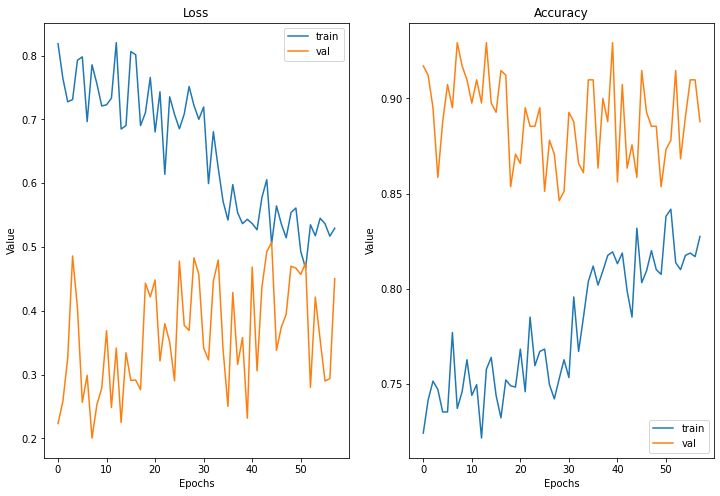

model_7
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 54ms/step - loss: 0.7922 - accuracy: 0.7249 - val_loss: 0.3075 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 47ms/step - loss: 0.6855 - accuracy: 0.7590 - val_loss: 0.3085 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 41ms/step - loss: 0.7628 - accuracy: 0.7422 - val_loss: 0.3265 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 46ms/step - loss: 0.7522 - accuracy: 0.7435 - val_loss: 0.2312 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7441 - accuracy: 0.7416 - val_loss: 0.2563 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7941 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.5324 - accuracy: 0.8120 - val_loss: 0.3639 - val_accuracy: 0.8878 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4882 - accuracy: 0.8241 - val_loss: 0.3635 - val_accuracy: 0.9049 - lr: 7.0000e-04
Epoch 54/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5646 - accuracy: 0.8057 - val_loss: 0.3686 - val_accuracy: 0.9073 - lr: 7.0000e-04
Epoch 55/500
51/51 [==============================] - 2s 42ms/step - loss: 0.5228 - accuracy: 0.8182 - val_loss: 0.3341 - val_accuracy: 0.9098 - lr: 4.9000e-04
Epoch 56/500
51/51 [==============================] - 2s 41ms/step - loss: 0.4799 - accuracy: 0.8319 - val_loss: 0.2859 - val_accuracy: 0.9073 - lr: 4.9000e-04
Epoch 57/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4168 - accuracy: 0.8462 - val_loss: 0.3442 - val_accuracy: 0.9024 - lr: 4.9000e-04


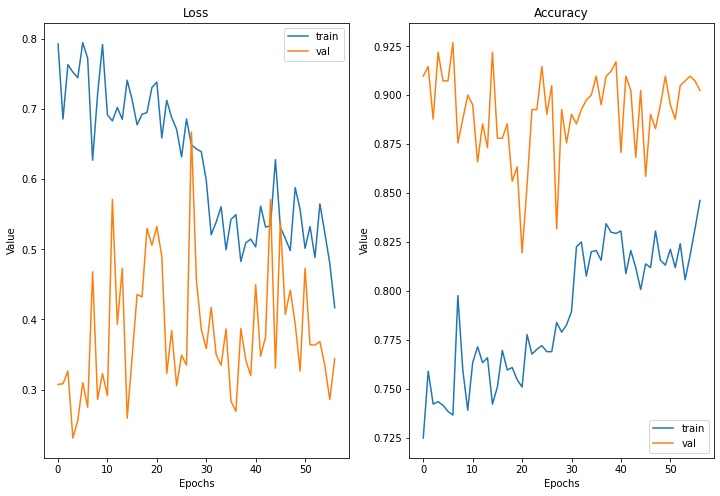

model_8
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 53ms/step - loss: 0.7689 - accuracy: 0.7426 - val_loss: 0.2081 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7101 - accuracy: 0.7559 - val_loss: 0.2031 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 45ms/step - loss: 0.7253 - accuracy: 0.7478 - val_loss: 0.1841 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7308 - accuracy: 0.7491 - val_loss: 0.1711 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7495 - accuracy: 0.7509 - val_loss: 0.3306 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6716 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.5144 - accuracy: 0.8244 - val_loss: 0.3044 - val_accuracy: 0.9049 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 43ms/step - loss: 0.5440 - accuracy: 0.8199 - val_loss: 0.4037 - val_accuracy: 0.8854 - lr: 7.0000e-04


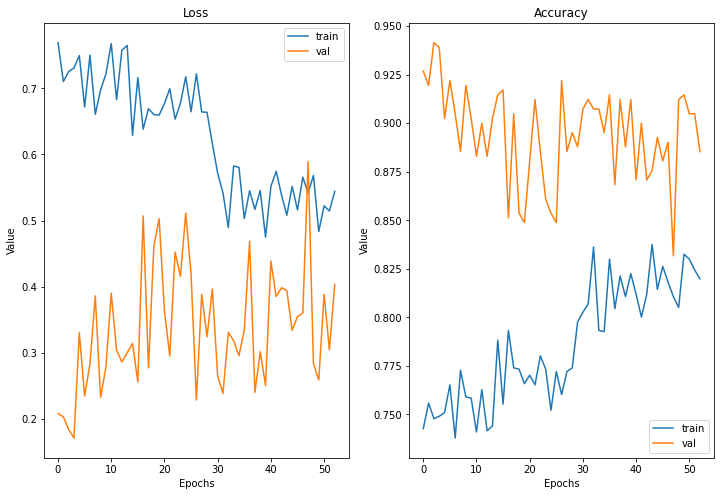

model_9
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 53ms/step - loss: 0.7880 - accuracy: 0.7488 - val_loss: 0.3936 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 46ms/step - loss: 0.7141 - accuracy: 0.7653 - val_loss: 0.2869 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 47ms/step - loss: 0.7299 - accuracy: 0.7379 - val_loss: 0.3316 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.7361 - accuracy: 0.7597 - val_loss: 0.4389 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 46ms/step - loss: 0.6935 - accuracy: 0.7677 - val_loss: 0.2978 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 41ms/step - loss: 0.6887 - accuracy: 0.

51/51 [==============================] - 2s 42ms/step - loss: 0.4655 - accuracy: 0.8344 - val_loss: 0.3673 - val_accuracy: 0.8976 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4540 - accuracy: 0.8444 - val_loss: 0.3582 - val_accuracy: 0.9000 - lr: 4.9000e-04
Epoch 54/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3937 - accuracy: 0.8587 - val_loss: 0.4005 - val_accuracy: 0.9000 - lr: 4.9000e-04
Epoch 55/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4383 - accuracy: 0.8474 - val_loss: 0.4068 - val_accuracy: 0.8683 - lr: 4.9000e-04
Epoch 56/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4482 - accuracy: 0.8394 - val_loss: 0.4030 - val_accuracy: 0.8951 - lr: 4.9000e-04
Epoch 57/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4151 - accuracy: 0.8531 - val_loss: 0.3689 - val_accuracy: 0.8976 - lr: 4.9000e-04
Epoch 58/500
51/51 [==============================] -

51/51 [==============================] - 2s 42ms/step - loss: 0.3280 - accuracy: 0.8848 - val_loss: 0.3603 - val_accuracy: 0.9098 - lr: 3.4300e-04
Epoch 104/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3167 - accuracy: 0.8898 - val_loss: 0.4046 - val_accuracy: 0.8927 - lr: 3.4300e-04
Epoch 105/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3167 - accuracy: 0.8873 - val_loss: 0.3538 - val_accuracy: 0.8976 - lr: 3.4300e-04
Epoch 106/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2921 - accuracy: 0.8991 - val_loss: 0.5456 - val_accuracy: 0.8902 - lr: 3.4300e-04
Epoch 107/500
51/51 [==============================] - 2s 41ms/step - loss: 0.3150 - accuracy: 0.8879 - val_loss: 0.4612 - val_accuracy: 0.9000 - lr: 3.4300e-04
Epoch 108/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2851 - accuracy: 0.9004 - val_loss: 0.4182 - val_accuracy: 0.9073 - lr: 3.4300e-04
Epoch 109/500
51/51 [===========================

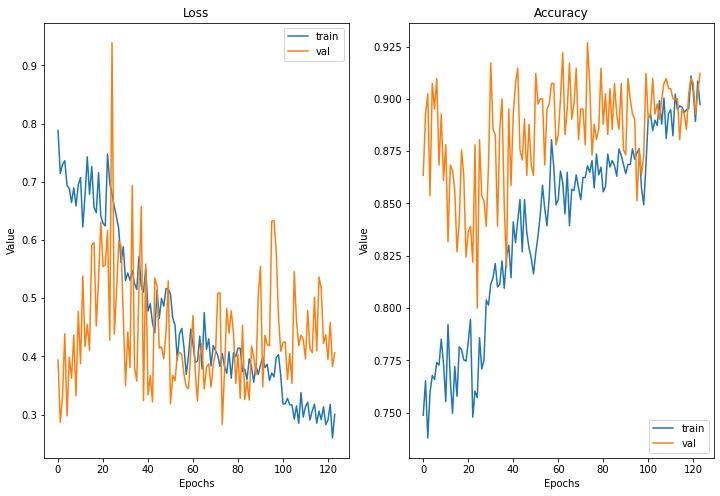

model_10
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
51/51 [==============================] - 3s 53ms/step - loss: 0.6485 - accuracy: 0.7953 - val_loss: 0.3047 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 2/500
51/51 [==============================] - 2s 45ms/step - loss: 0.6227 - accuracy: 0.7870 - val_loss: 0.2359 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 3/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6520 - accuracy: 0.7927 - val_loss: 0.1793 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 4/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6772 - accuracy: 0.7733 - val_loss: 0.3605 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 5/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6340 - accuracy: 0.7927 - val_loss: 0.2082 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 6/500
51/51 [==============================] - 2s 42ms/step - loss: 0.6282 - accuracy: 0

51/51 [==============================] - 2s 42ms/step - loss: 0.4460 - accuracy: 0.8499 - val_loss: 0.2631 - val_accuracy: 0.9390 - lr: 7.0000e-04
Epoch 53/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4585 - accuracy: 0.8370 - val_loss: 0.2340 - val_accuracy: 0.9390 - lr: 7.0000e-04
Epoch 54/500
51/51 [==============================] - 2s 43ms/step - loss: 0.3941 - accuracy: 0.8655 - val_loss: 0.2619 - val_accuracy: 0.9268 - lr: 4.9000e-04
Epoch 55/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3980 - accuracy: 0.8649 - val_loss: 0.2454 - val_accuracy: 0.9293 - lr: 4.9000e-04
Epoch 56/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3964 - accuracy: 0.8599 - val_loss: 0.2924 - val_accuracy: 0.9293 - lr: 4.9000e-04
Epoch 57/500
51/51 [==============================] - 2s 42ms/step - loss: 0.4250 - accuracy: 0.8499 - val_loss: 0.2387 - val_accuracy: 0.9366 - lr: 4.9000e-04
Epoch 58/500
51/51 [==============================] -

51/51 [==============================] - 2s 42ms/step - loss: 0.2825 - accuracy: 0.9029 - val_loss: 0.2550 - val_accuracy: 0.9366 - lr: 3.4300e-04
Epoch 104/500
51/51 [==============================] - 2s 41ms/step - loss: 0.2592 - accuracy: 0.9029 - val_loss: 0.2227 - val_accuracy: 0.9341 - lr: 3.4300e-04
Epoch 105/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2722 - accuracy: 0.9007 - val_loss: 0.3275 - val_accuracy: 0.9220 - lr: 3.4300e-04
Epoch 106/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2887 - accuracy: 0.9029 - val_loss: 0.2659 - val_accuracy: 0.9317 - lr: 3.4300e-04
Epoch 107/500
51/51 [==============================] - 2s 42ms/step - loss: 0.3089 - accuracy: 0.8854 - val_loss: 0.2099 - val_accuracy: 0.9463 - lr: 3.4300e-04
Epoch 108/500
51/51 [==============================] - 2s 42ms/step - loss: 0.2992 - accuracy: 0.8948 - val_loss: 0.3103 - val_accuracy: 0.9195 - lr: 3.4300e-04
Epoch 109/500
51/51 [===========================

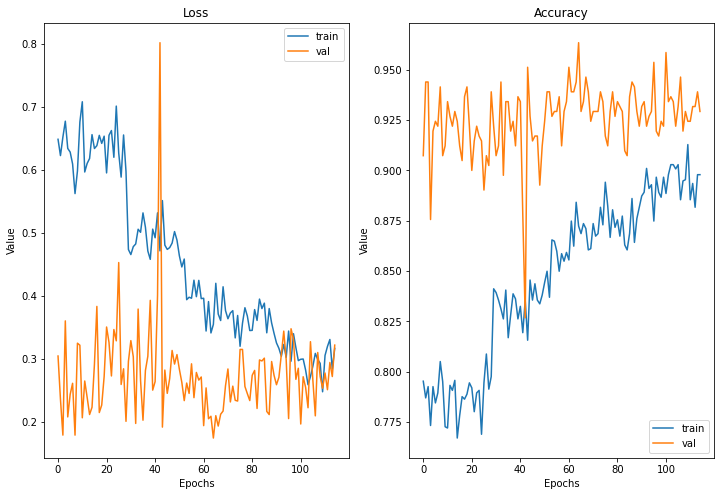

In [34]:
for idx in range(num_model):
    print("model_{}".format(idx+1))
    print("-------------------------------------------------------------------------------------------------------------------------")
    X_train, X_valid, y_train, y_valid = train_test_split(X_trains, y_trains, test_size=0.2, stratify=train['digit'])
    X_train = X_train/255.0
    X_valid = X_valid/255.
    
    model = None
    model = Model(inputs= [input_], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "model/deskewed_{}.h5".format(idx), save_best_only=True, monitor='val_accuracy', mode='auto')
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=25)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 50, restore_best_weights = True)
    
    history = model.fit_generator(datagen.flow(X_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs, validation_data=(
                                      X_valid, y_valid),
                                  verbose=1,
                                 steps_per_epoch=X_train.shape[0] // batch_size,
                                  validation_steps=X_valid.shape[0] //batch_size,
                                  callbacks=[checkpoint_cb, early_stopping, lr_scheduler]
                                  )
    plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

## Predict

In [35]:
X_test = X_test/255.0

In [36]:
best_model_list = []
for i in range(num_model):
    best = tf.keras.models.load_model('model/deskewed_{}.h5'.format(i))
    best_model_list.append(best)

In [37]:
result_list = []

for idx, model in enumerate(best_model_list):
    result = model.evaluate(X_valid, y_valid)
    print("model_{}_acc : {}".format(idx+1, result))

13/13 [==============================] - 14s 1s/step - loss: 0.1037 - accuracy: 0.9805
model_1_acc : [0.10373189300298691, 0.9804878234863281]
13/13 [==============================] - 0s 13ms/step - loss: 0.1924 - accuracy: 0.9439
model_2_acc : [0.19238002598285675, 0.9439024329185486]
13/13 [==============================] - 0s 11ms/step - loss: 0.1528 - accuracy: 0.9488
model_3_acc : [0.15281085669994354, 0.9487804770469666]
13/13 [==============================] - 0s 11ms/step - loss: 0.1921 - accuracy: 0.9341
model_4_acc : [0.19214259088039398, 0.9341463446617126]
13/13 [==============================] - 0s 11ms/step - loss: 0.1655 - accuracy: 0.9415
model_5_acc : [0.16548548638820648, 0.9414634108543396]
13/13 [==============================] - 0s 11ms/step - loss: 0.2035 - accuracy: 0.9390
model_6_acc : [0.203542098402977, 0.9390243887901306]
13/13 [==============================] - 0s 11ms/step - loss: 0.1745 - accuracy: 0.9390
model_7_acc : [0.1744978129863739, 0.93902438879013

In [38]:
pred_list = []
for idx, model in enumerate(best_model_list):
    pred = model.predict(X_test)
    pred_list.append(pred)

In [39]:
final_pred = np.array([0]*204800).reshape(20480, 10).astype('float64')
for pred in pred_list:
    final_pred += pred
final_pred = np.argmax(final_pred, axis=1)

In [40]:
final_pred

array([6, 8, 8, ..., 6, 3, 0])

In [41]:
submission['digit'] = final_pred

In [42]:
submission

,id,digit
0,2049,6
1,2050,8
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [43]:
submission.to_csv('./submission/rexnet_deskewed_submission.csv', index=False)